## AutoEncoder: Comparative Analysis

In [9]:
import numpy as np
import pandas as pd
import sys, os
import cv2
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import wandb 
from time import time
sys.path.append(os.path.abspath(os.path.join('..','..')))
from models.AutoEncoders.mlp_auto_encoder import MLPAutoEncoder
from models.knn.knn import OptimisedKNN as KNN
from performance_measures.performance_measures import Performance_Measures


### CNN AutoEncoder

#### `1. Data Loading and Preprocessing`

In [10]:
path_to_fashion_mnist = "../../data/external/fashion_mnist/"

def get_val():
    # split train csv and move 10k rows to val csv
    train_csv = pd.read_csv(path_to_fashion_mnist + "fashion_mnist_train.csv")
    val_csv = train_csv.sample(n=10000)
    train_csv = train_csv.drop(val_csv.index)
    train_csv.to_csv(path_to_fashion_mnist + "fashion_mnist_train.csv", index=False)
    val_csv.to_csv(path_to_fashion_mnist + "fashion_mnist_val.csv", index=False)

# get_val()


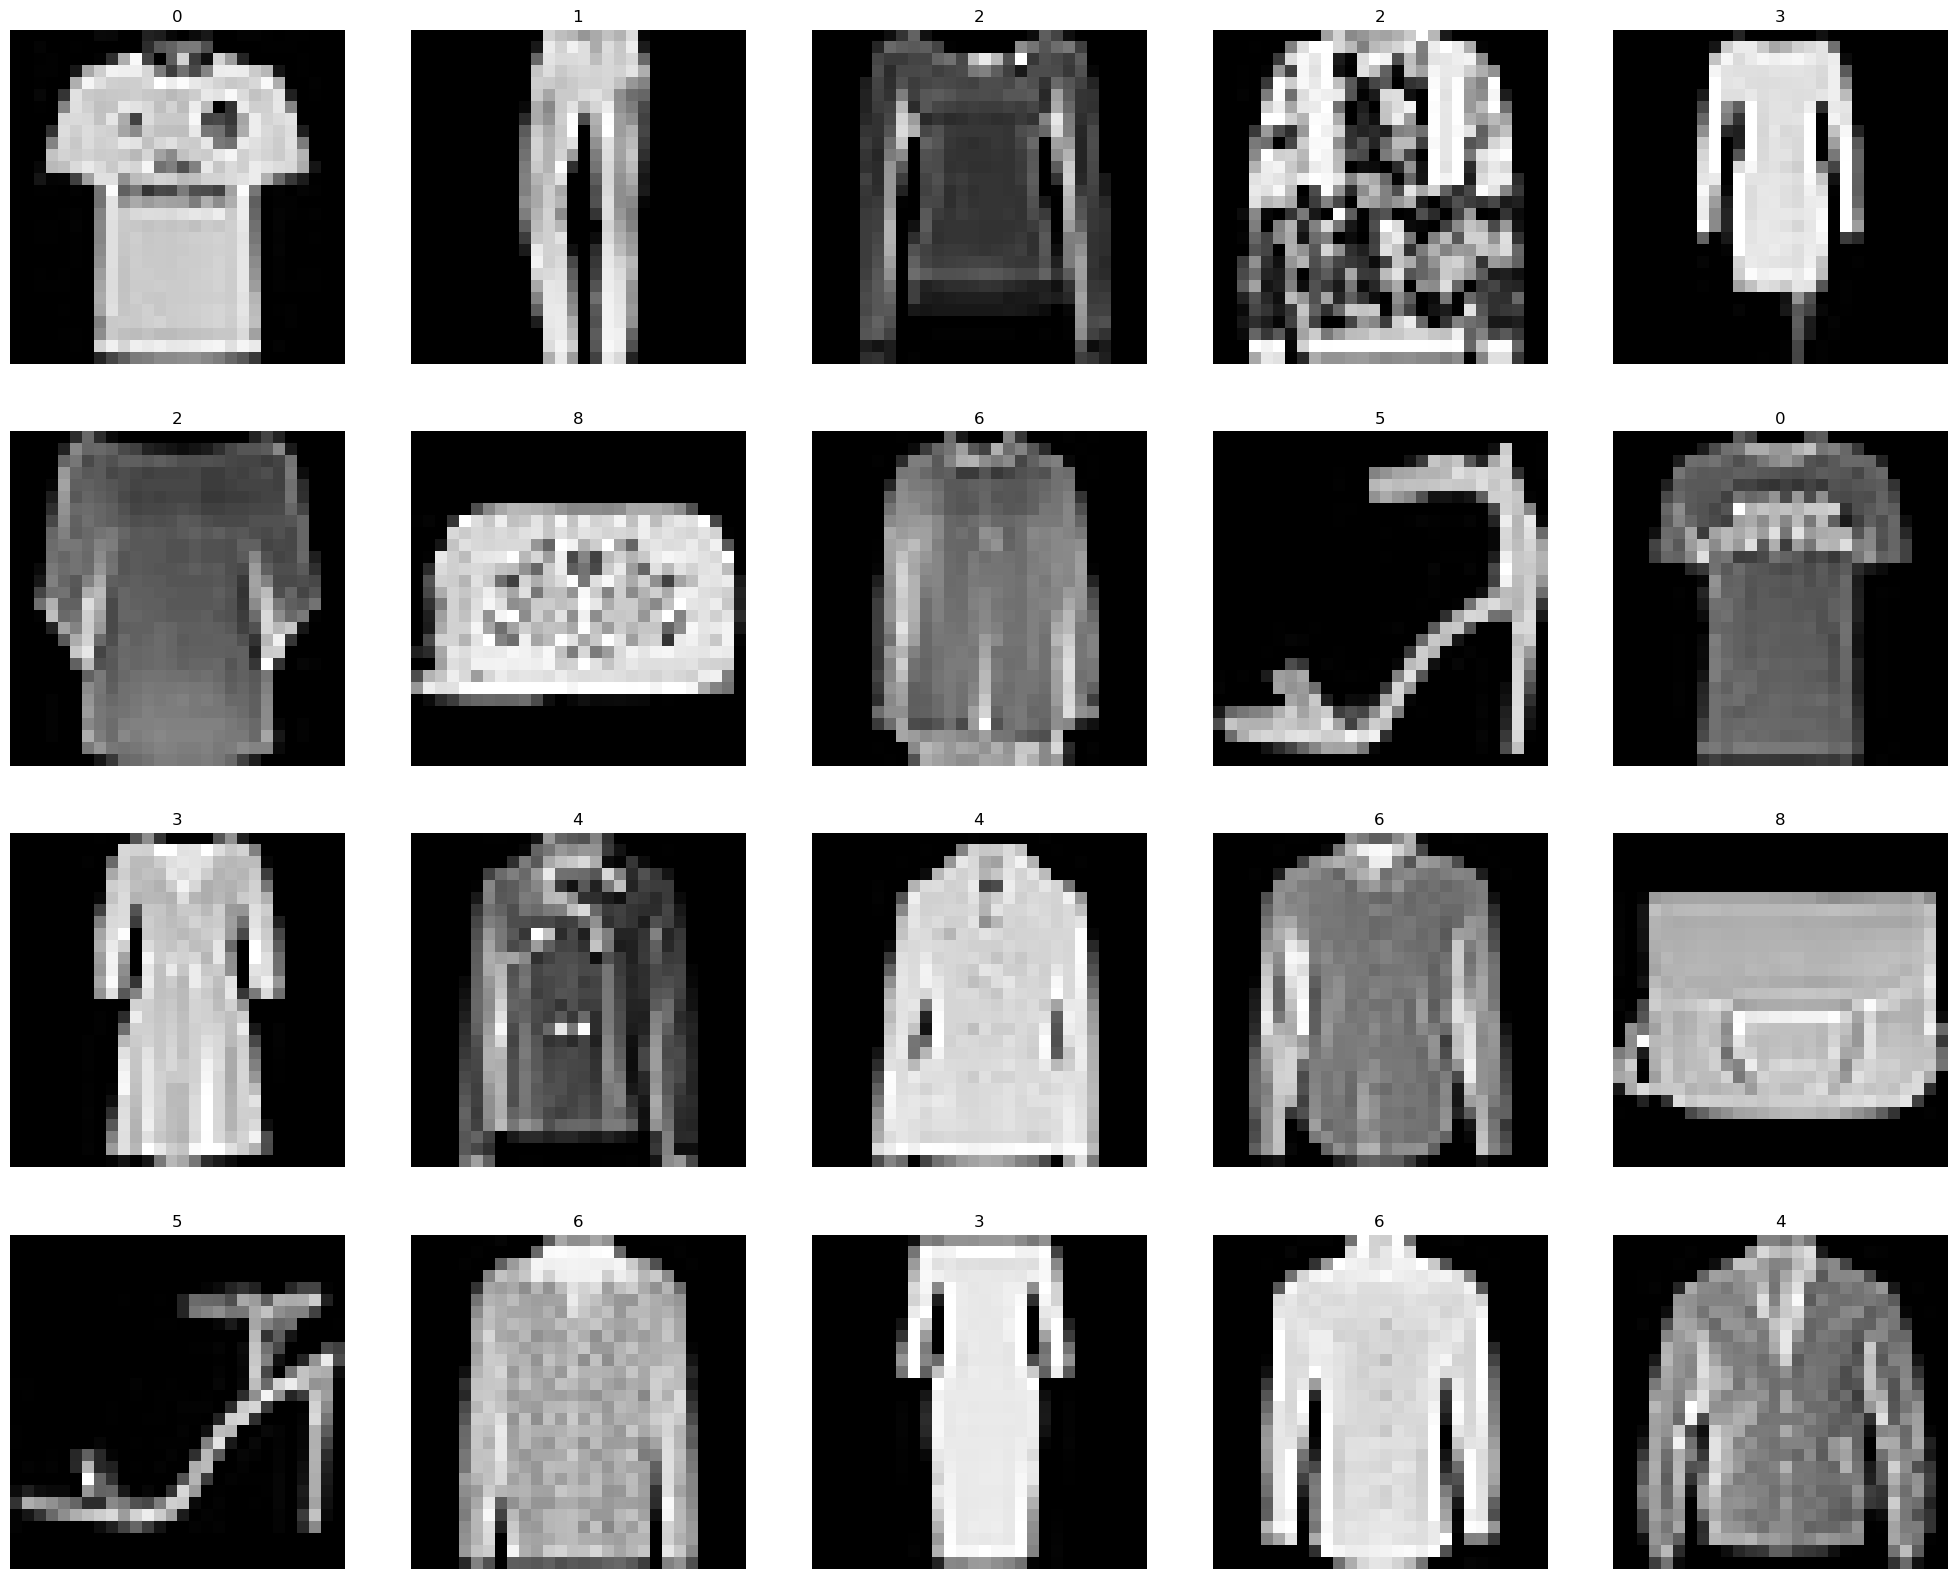

In [11]:
def visualise_images(path_to_fashion_mnist, num_images=20):
    df = pd.read_csv(path_to_fashion_mnist + "fashion_mnist_test.csv")

    fig, ax = plt.subplots(4, 5, figsize=(25, 20))
    ax = ax.ravel()
    for i in range(num_images):
        img = df.iloc[i, 1:].values.reshape(28, 28)
        label = df.iloc[i, 0]
        ax[i].imshow(img, cmap="gray")
        ax[i].axis("off")
        ax[i].set_title(label)
    plt.show()

visualise_images(path_to_fashion_mnist, num_images=20)


Guess for the labels:  
0: T Shirt  
1: Pant  
2: Jacket  
3: Dress  
4: Coat  
5: Footwear  
6: Shirt  
7: Sandal  
8: Bag  
9: Boot  

In [12]:
def load_data(path_to_fashion_mnist):
    class FashionMNISTDataset(Dataset):
        def __init__(self, csv_file, transform=None):
            self.data = pd.read_csv(csv_file)
            self.transform = transform

        def __len__(self):
            return len(self.data)

        def __getitem__(self, idx):
            img = self.data.iloc[idx, 1:].values.astype(np.uint8).reshape(28, 28, 1)
            label = self.data.iloc[idx, 0]
            if self.transform:
                img = self.transform(img)
            return img, label

    transform = transforms.Compose([transforms.ToTensor()])
    train_dataset = FashionMNISTDataset(path_to_fashion_mnist + "fashion_mnist_train.csv", transform=transform)
    val_dataset = FashionMNISTDataset(path_to_fashion_mnist + "fashion_mnist_val.csv", transform=transform)
    test_dataset = FashionMNISTDataset(path_to_fashion_mnist + "fashion_mnist_test.csv", transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    return train_loader, val_loader, test_loader

#### `2. CNN AutoEncoder`

In [13]:
class CNNAutoEncoder(nn.Module):
    def __init__(self):
        super(CNNAutoEncoder, self).__init__()

        # Encoder path: 28x28 -> 14x14 -> 7x7 -> 4x4
        self.encoder = nn.Sequential(
            # 28x28 -> 14x14
            nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            
            # 14x14 -> 7x7
            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            
            # 7x7 -> 4x4
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),  
        )

        # latent dim = 16*4*4 = 256

        # Decoder path: 4x4 -> 7x7 -> 14x14 -> 28x28
        self.decoder = nn.Sequential(
            
            # 4x4 -> 7x7
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, stride=2, padding=1, output_padding=0),
            nn.ReLU(True),
            
            # 7x7 -> 14x14
            nn.ConvTranspose2d(in_channels=8, out_channels=4, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            
            # 14x14 -> 28x28
            nn.ConvTranspose2d(in_channels=4, out_channels=1, kernel_size=4, stride=2, padding=1, output_padding=0),
            nn.Sigmoid()
        )

    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, x):
        return self.decoder(x)
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [14]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, device="cpu", wandb_log=False, logging=False):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for i, (img, _) in enumerate(train_loader):
            img = img.to(device)
            optimizer.zero_grad()
            output = model(img)
            loss = criterion(output, img)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for i, (img, _) in enumerate(val_loader):
                img = img.to(device)
                output = model(img)
                loss = criterion(output, img)
                val_loss += loss.item()
            
            val_loss /= len(val_loader)
        
        if logging:
            print(f"Epoch {epoch+1}/{num_epochs} => Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        if wandb_log:
            wandb.log({"Train Loss": train_loss, "Val Loss": val_loss})

        train_losses.append(train_loss)
        val_losses.append(val_loss)

    return train_losses, val_losses


In [15]:
def train_driver(
        num_epochs=10,
        optimizer_type="adam",
        device="cpu",
        lr=0.001,
        wandb_log=False,
        logging=True,
        return_losses=False):
    
    model = CNNAutoEncoder()
    model.to(device)
    if optimizer_type == "adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr)

    criterion = nn.MSELoss()

    train_loader, val_loader, test_loader = load_data(path_to_fashion_mnist)
    train_losses, val_losses = train(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs, device=device, wandb_log=wandb_log, logging=logging)

    if return_losses:
        return model, train_loader, val_loader, test_loader, train_losses, val_losses
    else:
        return model, train_loader, val_loader, test_loader

In [16]:
def test_model(model, test_loader, criterion, device="cpu"):
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for i, (img, _) in enumerate(test_loader):
            img = img.to(device)
            output = model(img)
            loss = criterion(output, img)
            test_loss += loss.item()
        test_loss /= len(test_loader)
    print(f"Test MSE Loss: {test_loss:.4f}")

    return test_loss


In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"
cnn_autoencoder_model, train_loader, val_loader, test_loader = train_driver(num_epochs=10, optimizer_type="adam", device=device, lr=0.001, wandb_log=False, logging=True)

Epoch 1/10 => Train Loss: 0.0394, Val Loss: 0.0184
Epoch 2/10 => Train Loss: 0.0164, Val Loss: 0.0148
Epoch 3/10 => Train Loss: 0.0137, Val Loss: 0.0127
Epoch 4/10 => Train Loss: 0.0121, Val Loss: 0.0115
Epoch 5/10 => Train Loss: 0.0111, Val Loss: 0.0106
Epoch 6/10 => Train Loss: 0.0103, Val Loss: 0.0100
Epoch 7/10 => Train Loss: 0.0098, Val Loss: 0.0095
Epoch 8/10 => Train Loss: 0.0093, Val Loss: 0.0090
Epoch 9/10 => Train Loss: 0.0089, Val Loss: 0.0087
Epoch 10/10 => Train Loss: 0.0085, Val Loss: 0.0084


In [12]:
_ = test_model(cnn_autoencoder_model, test_loader, nn.MSELoss(), device=device)

Test MSE Loss: 0.0081


#### `3. Plots and Visualizations`

In [53]:
def visualise_reconstruction(model, test_loader, num_images=5, device="cpu"):
    model.eval()
    fig, ax = plt.subplots(2, num_images, figsize=(25, 10))
    ax = ax.ravel()
    with torch.no_grad():
        for i, (img, _) in enumerate(test_loader):
            if i == num_images:
                break
            img = img.to(device)
            output = model(img)
            # print(img.shape, output.shape)
            # img and output size is batch x 1 x 28 x 28
            ax[i].imshow(img[0][0], cmap="gray")
            ax[i].axis("off")
            ax[i].set_title("Original")
            ax[i+num_images].imshow(output[0][0].cpu(), cmap="gray")
            ax[i+num_images].axis("off")
            ax[i+num_images].set_title("Reconstructed")

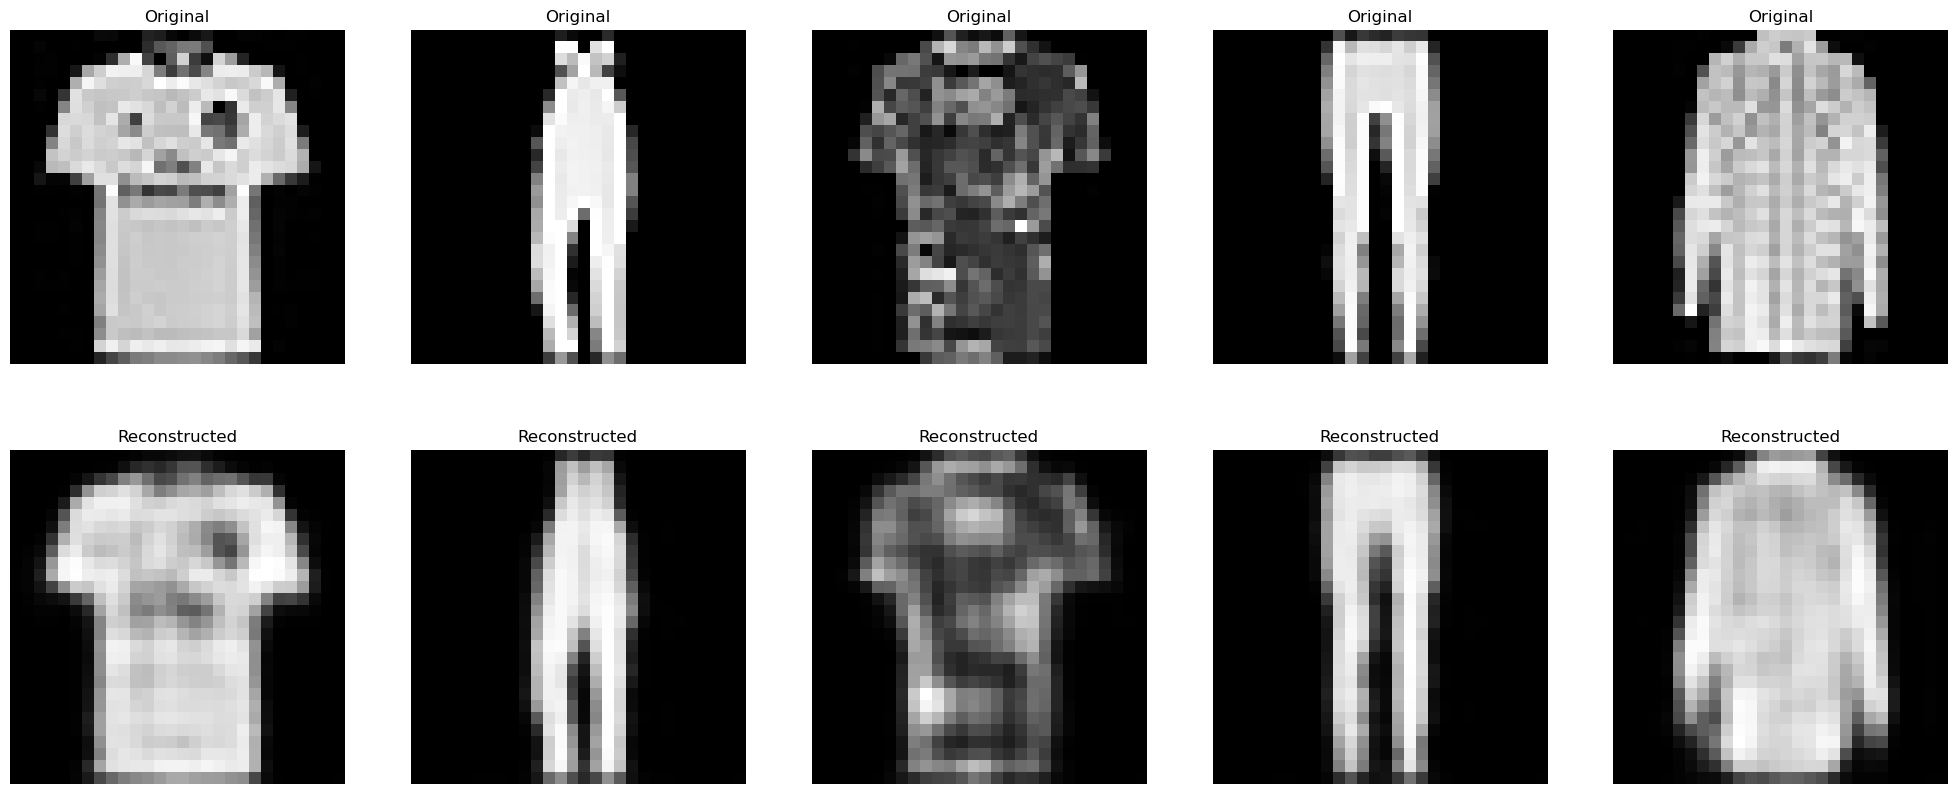

In [54]:
visualise_reconstruction(cnn_autoencoder_model, test_loader, num_images=5, device=device)

In [55]:
def visualise_latent_space(model, test_loader, device="cpu"):
    model.eval()
    latents = []
    labels_list = []
    with torch.no_grad():
        for i, (img, labels) in enumerate(test_loader):
            img = img.to(device)
            latent = model.encode(img)
            latents.append(latent.view(latent.size(0), -1).cpu().numpy())
            labels_list.append(labels.cpu().numpy())
    latents = np.concatenate(latents, axis=0)
    labels = np.concatenate(labels_list, axis=0)

    return latents, labels

latents, labels = visualise_latent_space(cnn_autoencoder_model, test_loader, device=device)

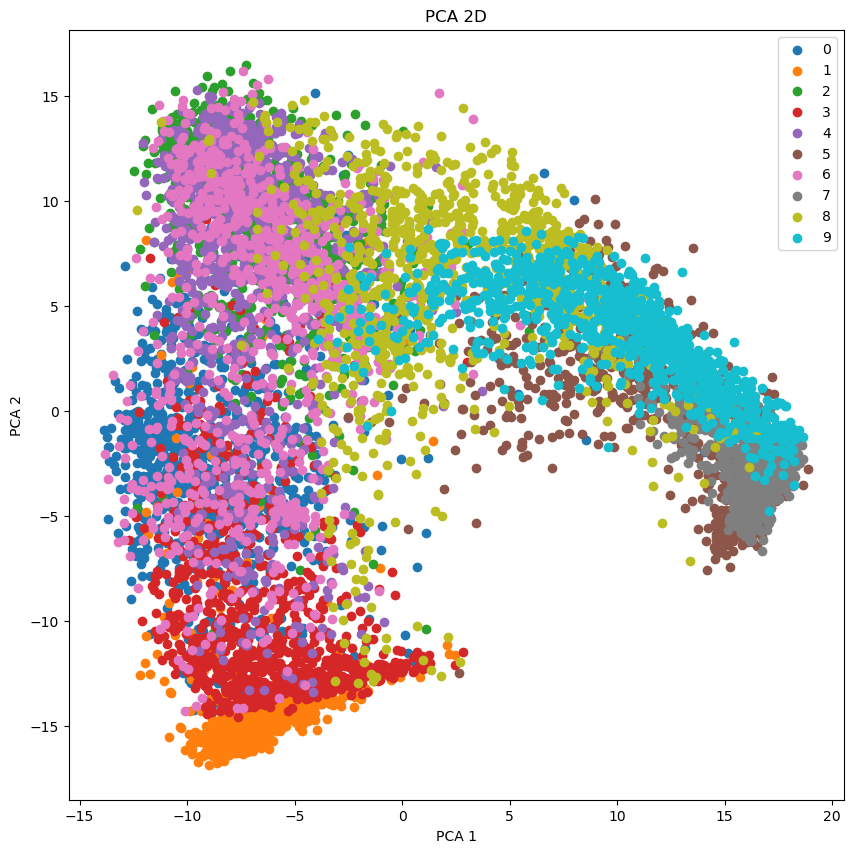

In [56]:
plt.figure(figsize=(10, 10))

pca_2D = PCA(n_components=2)
latents_2D = pca_2D.fit_transform(latents)
for i in range(10):
    plt.scatter(latents_2D[labels == i, 0], latents_2D[labels == i, 1], label=str(i))
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.title("PCA 2D")
plt.show()


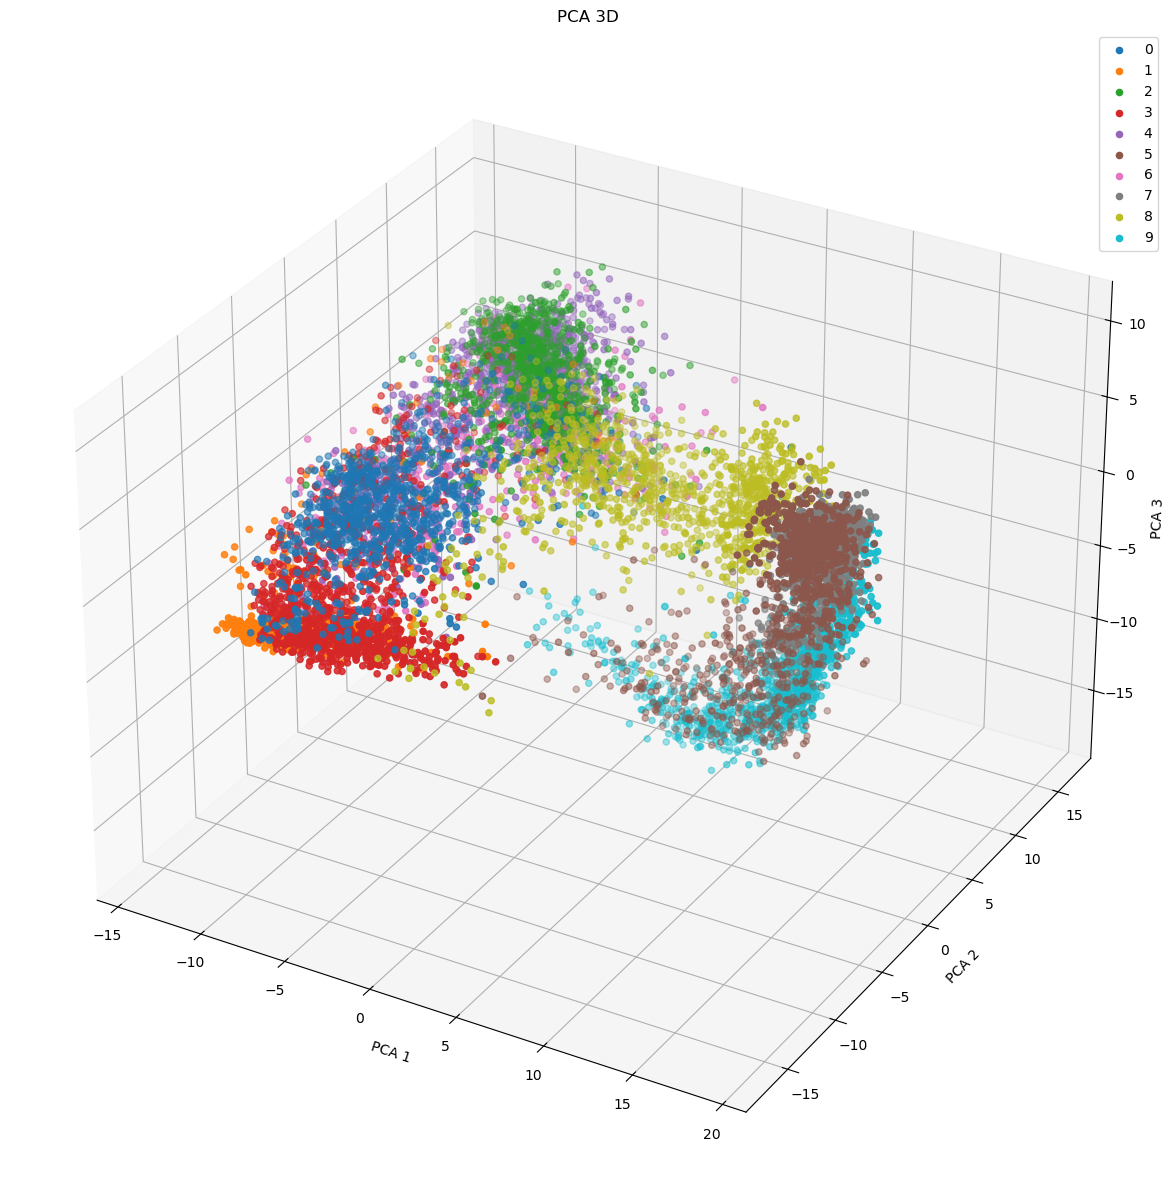

In [57]:
pca_3D = PCA(n_components=3)
latents_3D = pca_3D.fit_transform(latents)
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(111, projection="3d")
for i in range(10):
    ax.scatter(latents_3D[labels == i, 0], latents_3D[labels == i, 1], latents_3D[labels == i, 2], label=str(i))
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")
plt.legend()
plt.title("PCA 3D")
plt.show()


It is clear from the above plots that similar images are clustered together. That means the autoencoder is able to learn the features of the images and group them together well.

#### `4. Hyperparameter Tuning`

In [58]:
def sweep_train():
    with wandb.init() as run:
        config = run.config
        wandb.run.name = f"{config.optimizer_type}_{config.lr}_{config.epochs}"
        model, train_loader, val_loader, test_loader = train_driver(
            num_epochs=config.epochs,
            optimizer_type=config.optimizer_type,
            device=device,
            lr=config.lr,
            wandb_log=True,
            logging=False
        )
        
        test_loss = test_model(model, test_loader, nn.MSELoss(), device=device)
        wandb.log({"Test Loss": test_loss})
        


def hyperparameter_tuning():
    sweep_config = {
        'method': 'grid',
        'metric': {
            'name': 'val_loss',
            'goal': 'minimize'
        },
        'parameters': {
            'epochs': {
                'values': [10, 15]
            },
            'optimizer_type': {
                'values': ['adam', 'sgd']
            },
            'lr': {
                'values': [0.001, 0.01]
            }
        }
    }

    sweep_id = wandb.sweep(sweep_config, project='SMAI_ASG_4_CNN_AutoEncoder')
    wandb.agent(sweep_id, function=sweep_train)

In [ ]:
# hyperparameter_tuning()

Refer to the wandb link for the plots of the val and train loss obtained during hyperparameter tuning.  
[Wandb Link](https://wandb.ai/abhinav7/SMAI_ASG_4_CNN_AutoEncoder)

The best model is with:  
- lr: 0.01  
- no of epochs: 15  
- optimizer: Adam   

The MSE val loss is 0.006  
The MSE train loss is 0.006  

In [62]:
# 3-layer version (Original)
class CNNAutoEncoder3Layer(nn.Module):
    def __init__(self):
        super(CNNAutoEncoder3Layer, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 4, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(4, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.ReLU(True),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=0),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 4, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(4, 1, 4, stride=2, padding=1, output_padding=0),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# 2-layer version (Shallower)
class CNNAutoEncoder2Layer(nn.Module):
    def __init__(self):
        super(CNNAutoEncoder2Layer, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=3, padding=1),
            nn.ReLU(True),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 8, 3, stride=3, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# 4-layer version (Deeper)
class CNNAutoEncoder4Layer(nn.Module):
    def __init__(self):
        super(CNNAutoEncoder4Layer, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 4, 3, stride=1, padding=1),
            nn.ReLU(True),
            nn.Conv2d(4, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 12, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(12, 16, 3, stride=2, padding=1),
            nn.ReLU(True),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 12, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(12, 8, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 4, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(4, 1, 3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [67]:
time_1 = time()
layer_2_model, _, _, _, layer_2_train_losses, layer_2_val_losses = train_driver(num_epochs=10, optimizer_type="adam", device=device, lr=0.001, wandb_log=False, logging=True, return_losses=True)
time_2 = time()
print(f"2-layer model took {time_2 - time_1:.2f} seconds")
layer_3_model, _, _, _, layer_3_train_losses, layer_3_val_losses = train_driver(num_epochs=10, optimizer_type="adam", device=device, lr=0.001, wandb_log=False, logging=True, return_losses=True)
time_3 = time()
print(f"3-layer model took {time_3 - time_2:.2f} seconds")
layer_4_model, _, _, _, layer_4_train_losses, layer_4_val_losses = train_driver(num_epochs=10, optimizer_type="adam", device=device, lr=0.001, wandb_log=False, logging=True, return_losses=True)
time_4 = time()
print(f"4-layer model took {time_4 - time_3:.2f} seconds")


Epoch 1/10 => Train Loss: 0.0499, Val Loss: 0.0193
Epoch 2/10 => Train Loss: 0.0162, Val Loss: 0.0143
Epoch 3/10 => Train Loss: 0.0131, Val Loss: 0.0122
Epoch 4/10 => Train Loss: 0.0116, Val Loss: 0.0110
Epoch 5/10 => Train Loss: 0.0107, Val Loss: 0.0102
Epoch 6/10 => Train Loss: 0.0100, Val Loss: 0.0096
Epoch 7/10 => Train Loss: 0.0094, Val Loss: 0.0092
Epoch 8/10 => Train Loss: 0.0090, Val Loss: 0.0089
Epoch 9/10 => Train Loss: 0.0088, Val Loss: 0.0087
Epoch 10/10 => Train Loss: 0.0085, Val Loss: 0.0084
2-layer model took 80.28 seconds
Epoch 1/10 => Train Loss: 0.0481, Val Loss: 0.0189
Epoch 2/10 => Train Loss: 0.0171, Val Loss: 0.0156
Epoch 3/10 => Train Loss: 0.0146, Val Loss: 0.0138
Epoch 4/10 => Train Loss: 0.0133, Val Loss: 0.0127
Epoch 5/10 => Train Loss: 0.0123, Val Loss: 0.0118
Epoch 6/10 => Train Loss: 0.0115, Val Loss: 0.0112
Epoch 7/10 => Train Loss: 0.0110, Val Loss: 0.0108
Epoch 8/10 => Train Loss: 0.0106, Val Loss: 0.0103
Epoch 9/10 => Train Loss: 0.0102, Val Loss: 0.01

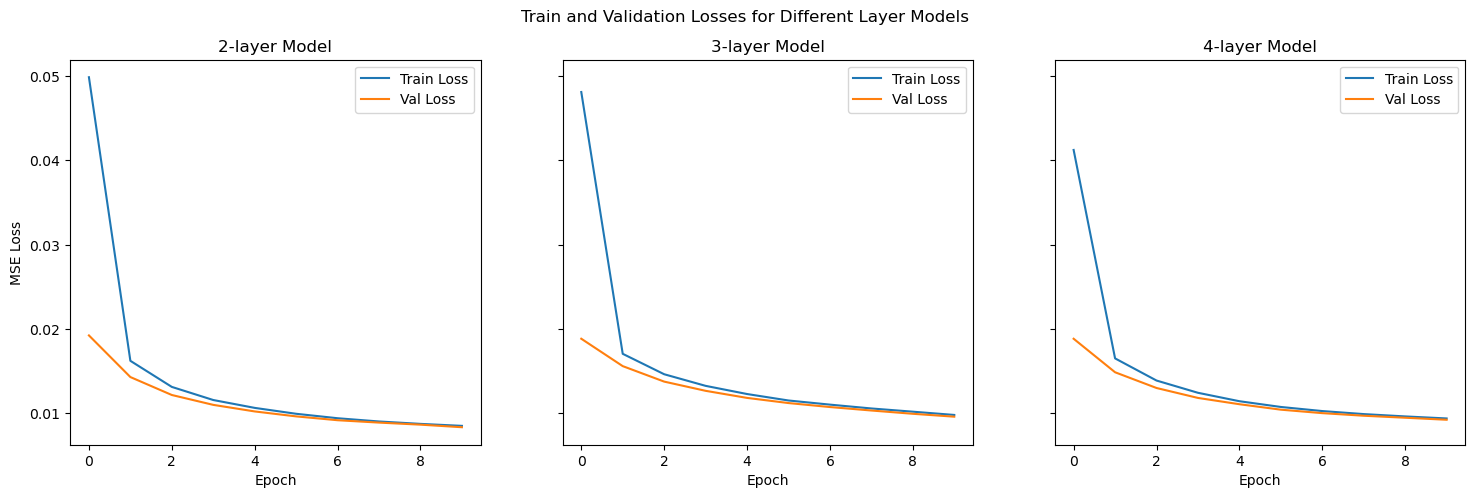

In [69]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# 2-layer model
axs[0].plot(layer_2_train_losses, label="Train Loss")
axs[0].plot(layer_2_val_losses, label="Val Loss")
axs[0].set_title("2-layer Model")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("MSE Loss")
axs[0].legend()

# 3-layer model
axs[1].plot(layer_3_train_losses, label="Train Loss")
axs[1].plot(layer_3_val_losses, label="Val Loss")
axs[1].set_title("3-layer Model")
axs[1].set_xlabel("Epoch")
axs[1].legend()

# 4-layer model
axs[2].plot(layer_4_train_losses, label="Train Loss")
axs[2].plot(layer_4_val_losses, label="Val Loss")
axs[2].set_title("4-layer Model")
axs[2].set_xlabel("Epoch")
axs[2].legend()

fig.suptitle("Train and Validation Losses for Different Layer Models")
plt.show()


The time taken for the deeper model is higher than the shallower one. As the depth of the model increases, the time taken for training also increases. (80s, 87s, 104s) for 2, 3, 4 layers respectively.

All models appear to converge quickly within the first few epochs, with most of the drop in loss occurring within the first 3 epochs. The rate of convergence does not significantly differ across the 2-layer, 3-layer, and 4-layer models.

The final training and validation losses for all three configurations (2-layer, 3-layer, and 4-layer) are quite similar and converge to very low values. This suggests that increasing the number of layers does not drastically improve the model's ability to minimize the loss in this case.

There is minimal difference between the training and validation loss curves (they are very close to each other) across all configurations, which indicates there is no overfitting. This might suggest that the dataset or task complexity is not high enough to benefit significantly from additional layers.

Hence the 2-layer model is the best model as it has the least time taken and the same loss as the other models.

### MLP AutoEncoder

In [18]:
mlp_auto_encoder = MLPAutoEncoder(
    l_r=0.01,
    activation_function='sigmoid',
    optimizer='mini_batch_gradient_descent',
    hidden_layers=1,
    neurons_per_layer=[512],
    reduced_dimension=256,
    batch_size=32,
    no_of_epochs=20,
    input_layer_size=28*28
)

train_data_mlp = "../../data/external/fashion_mnist/fashion_mnist_train.csv"
val_data_mlp = "../../data/external/fashion_mnist/fashion_mnist_val.csv"
test_data_mlp = "../../data/external/fashion_mnist/fashion_mnist_test.csv"

train_data = pd.read_csv(train_data_mlp)
val_data = pd.read_csv(val_data_mlp)
test_data = pd.read_csv(test_data_mlp)

# normalised the data to [0,1]

X_train = train_data.iloc[:,1:].values / 255.0
X_val = val_data.iloc[:,1:].values / 255.0
X_test = test_data.iloc[:,1:].values / 255.0

train_losses, val_losses = mlp_auto_encoder.fit(X=X_test, val=True, X_val=X_val, early_stopping=True, patience=5)
print("Reconstruction Loss: ", mlp_auto_encoder.reconstruction_loss(X_test))


Epoch: 1/20, Error: 0.024574029382484663
Epoch: 2/20, Error: 0.022020345058874978
Epoch: 3/20, Error: 0.01945723624241826
Epoch: 4/20, Error: 0.01754617768925503
Epoch: 5/20, Error: 0.01543088317800808
Epoch: 6/20, Error: 0.014621841582845237
Epoch: 7/20, Error: 0.014226221571906564
Epoch: 8/20, Error: 0.013744836992879662
Epoch: 9/20, Error: 0.013414644949235478
Epoch: 10/20, Error: 0.013015889028541061
Epoch: 11/20, Error: 0.012666702881272038
Epoch: 12/20, Error: 0.012360215496620107
Epoch: 13/20, Error: 0.01210340394534217
Epoch: 14/20, Error: 0.011883511716035699
Epoch: 15/20, Error: 0.011688358679168549
Epoch: 16/20, Error: 0.011512471986109378
Epoch: 17/20, Error: 0.011351503582438157
Epoch: 18/20, Error: 0.011205957532702648
Epoch: 19/20, Error: 0.011073569768799757
Epoch: 20/20, Error: 0.010958145493421511
Reconstruction Loss:  0.021916290986843022


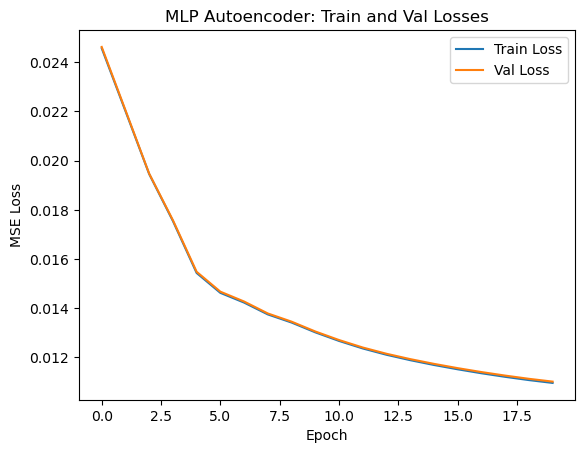

In [19]:
# plot losses

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("MLP Autoencoder: Train and Val Losses")

plt.show()

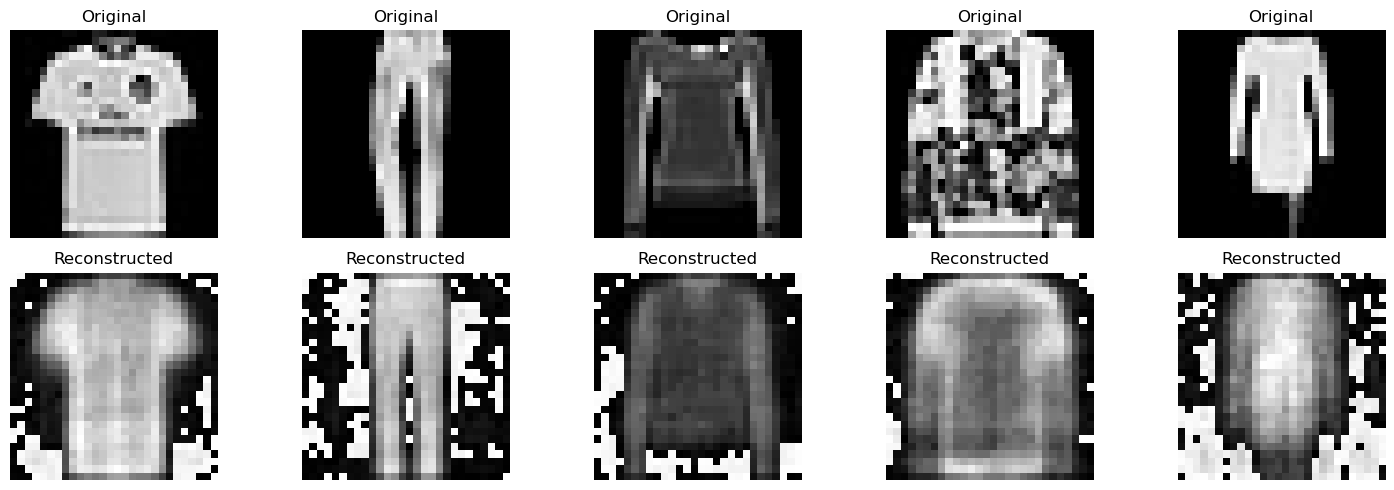

In [20]:
num_images = 5

reconstructed = mlp_auto_encoder.get_reconstructed(X_test)

fig, axes = plt.subplots(2, num_images, figsize=(15, 5))
for i in range(num_images):
    # Original image
    original = X_test[i].reshape(28, 28)
    axes[0, i].imshow(original, cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title("Original")

    # Reconstructed image
    reconst = reconstructed[i].reshape(28, 28)
    reconst *= 255
    reconst = reconst.astype(np.uint8)
    axes[1, i].imshow(reconst, cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title("Reconstructed")

plt.tight_layout()
plt.show()

From the above figures its clear that the reconstructed images are similar to the original ones but the quality degrades drastically. MLP autoencoder performs worse than CNN autoencoder. 
Even after normalising the data to 0,1 the loss is around 0.02 whereas for CNN its < 0.005

## PCA AutoEncoder

In [21]:
class PcaAutoencoder:
    def __init__(self, num_components=None):
        if num_components == None:
            raise ValueError("Provide number of components")
        self.num_components = num_components
        self.mean = None
        self.eigenvectors = None

    def fit(self, X):
        """
        Calculates the mean, eigenvalues, and eigenvectors of the input data.
        """
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean
        
        covariance_matrix = np.cov(X_centered, rowvar=False)
        
        eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
        
        sorted_indices = np.argsort(eigenvalues)[::-1]
        self.eigenvectors = eigenvectors[:, sorted_indices]
        self.eigenvalues = eigenvalues[sorted_indices]
        
        self.eigenvectors = self.eigenvectors[:, :self.num_components]

    def encode(self, X):
        """
        Reduces the dimensionality of the input data using learned eigenvectors.
        """
        X_centered = X - self.mean
        encoded = np.dot(X_centered, self.eigenvectors)
        return encoded

    def forward(self, X):
        """
        Reconstructs the data from the reduced representation.
        """
        encoded = self.encode(X)
        reconstructed = np.dot(encoded, self.eigenvectors.T) + self.mean
        return reconstructed

    def reconstruction_loss(self, X, X_reconstructed):
        """
        Calculates the mean squared error between the original and reconstructed data.
        """
        return np.mean((X - X_reconstructed) ** 2)


In [22]:
def elbow_plot_pca_autoencoder(component_range):
    reconstruction_errors = []
    component_range = component_range

    for num_components in component_range:
        pca_autoencoder = PcaAutoencoder(num_components=num_components)
        pca_autoencoder.fit(X_train)
        X_reconstructed = pca_autoencoder.forward(X_val)
        error = pca_autoencoder.reconstruction_loss(X_val, X_reconstructed)
        reconstruction_errors.append(error)

    # elbow plot
    plt.figure(figsize=(10, 6))
    plt.plot(component_range, reconstruction_errors, marker='o')
    plt.xlabel("Number of Components")
    plt.ylabel("Reconstruction Error (MSE)")
    plt.title("Elbow Plot of Reconstruction Error vs. Number of Components")
    plt.show()

    return reconstruction_errors

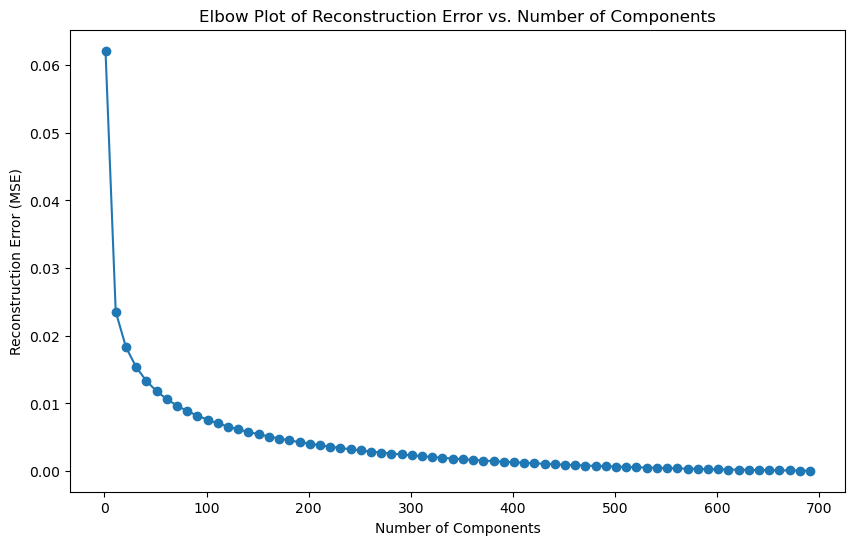

In [68]:
reconstruction_errors = elbow_plot_pca_autoencoder(range(1, 700, 10))

From here the number of components can be roughly around 250. The loss graph is almost flat after 250 components. Hence the number of components can be taken to be around 250.  
For the previous encoders, the latent dimension was a power of 2, we can keep the latent dimension as 256.

$k_{optimal} = 256$

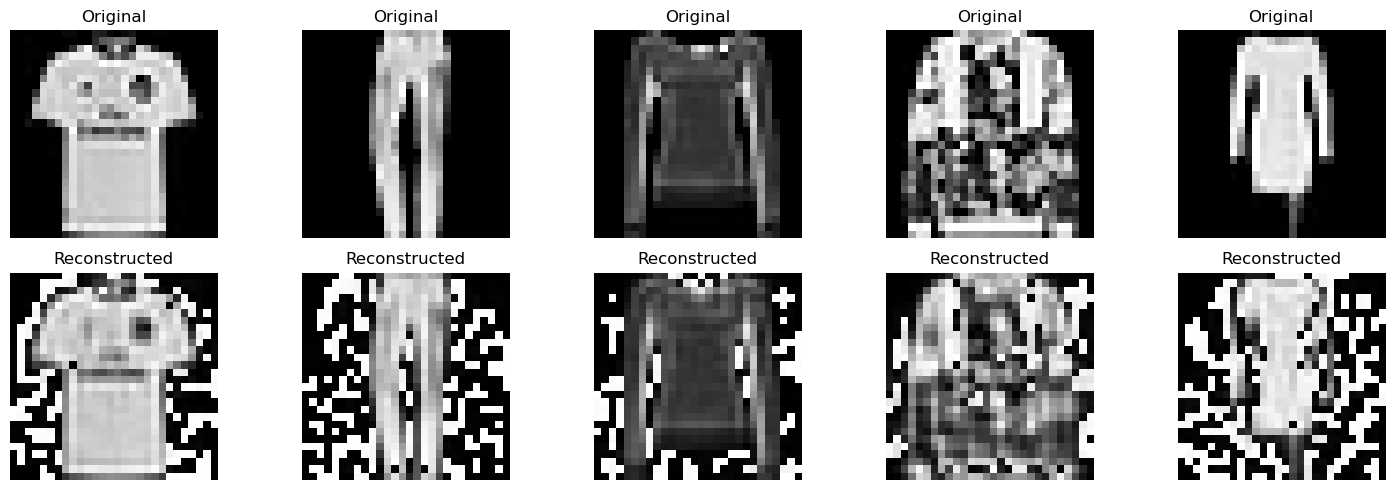

In [23]:
num_images = 5

pca_auto_encoder = PcaAutoencoder(num_components=256)
pca_auto_encoder.fit(X_train)
reconstructed_pca = pca_auto_encoder.forward(X_test)

fig, axes = plt.subplots(2, num_images, figsize=(15, 5))
for i in range(num_images):
    # Original image
    original = X_test[i].reshape(28, 28)
    axes[0, i].imshow(original, cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title("Original")

    # Reconstructed image
    reconst = reconstructed_pca[i].reshape(28, 28)
    reconst *= 255
    reconst = reconst.astype(np.uint8)
    axes[1, i].imshow(reconst, cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title("Reconstructed")

plt.tight_layout()
plt.show()

With PCA, the reconstructed images are somewhat similar to the original ones but the quality degrades drastically here as well. 

Among the 3 autoencoders, CNN, MLP and PCA, CNN performs the best followed by PCA and then MLP.

The CNN autoencoder is able to learn the features of the images and group them together well. The quality of the reconstructed images is also better than the other two autoencoders. With MLP the background of the clothing is pixelated and the foreground is blurred. With PCA they are able to somewhat maintain the details of the foreground but the background is pixelated.

## KNN Classification

Note:
- The CNN Autoencoder performs poorly when the data is normalised to 0,1. So, for CNN Autoencoder the data is not normalised.
- For MLP and PCA Autoencoder the data is normalised to 0,1. As in their case, the loss is very high when the data is not normalised.

In [24]:
X_train_cnn = train_data.iloc[:,1:].values
X_val_cnn = val_data.iloc[:,1:].values
X_test_cnn = test_data.iloc[:,1:].values


y_train = train_data.iloc[:,0].values
y_val = val_data.iloc[:,0].values
y_test = test_data.iloc[:,0].values

In [25]:
cnn_latent_train = cnn_autoencoder_model.encode(torch.tensor(X_train_cnn.reshape(-1, 1, 28, 28), dtype=torch.float32)).detach().numpy().reshape(-1, 256)
mlp_latent_train = mlp_auto_encoder.get_latent(X_train)
pca_latent_train = pca_auto_encoder.encode(X_train)

cnn_latent_test = cnn_autoencoder_model.encode(torch.tensor(X_test_cnn.reshape(-1, 1, 28, 28), dtype=torch.float32)).detach().numpy().reshape(-1, 256)
mlp_latent_test = mlp_auto_encoder.get_latent(X_test)
pca_latent_test = pca_auto_encoder.encode(X_test)

In [26]:
print("CNN Latent Shape: ", cnn_latent_train.shape)
print("MLP Latent Shape: ", mlp_latent_train.shape)
print("PCA Latent Shape: ", pca_latent_train.shape)

print("CNN Latent Test Shape: ", cnn_latent_test.shape)
print("MLP Latent Test Shape: ", mlp_latent_test.shape)
print("PCA Latent Test Shape: ", pca_latent_test.shape)

print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)


CNN Latent Shape:  (50000, 256)
MLP Latent Shape:  (50000, 256)
PCA Latent Shape:  (50000, 256)
CNN Latent Test Shape:  (10000, 256)
MLP Latent Test Shape:  (10000, 256)
PCA Latent Test Shape:  (10000, 256)
y_train shape:  (50000,)
y_test shape:  (10000,)


In [27]:
knn_cnn = KNN(k=5)
knn_cnn.fit(cnn_latent_train, y_train)
knn_cnn_predictions_test = knn_cnn.predict(cnn_latent_test)

Progress: [########################################] 100%


In [29]:
pm = Performance_Measures()
cnn_test_accuracy = pm.accuracy(y_test, knn_cnn_predictions_test)
print("CNN Test Accuracy: ", cnn_test_accuracy)

CNN Test Accuracy:  0.8517


In [30]:
knn_mlp = KNN(k=5)
knn_mlp.fit(mlp_latent_train, y_train)
knn_mlp_predictions_test = knn_mlp.predict(mlp_latent_test)

Progress: [########################################] 100%


In [31]:
mlp_test_accuracy = pm.accuracy(y_test, knn_mlp_predictions_test)
print("MLP Test Accuracy: ", mlp_test_accuracy)

MLP Test Accuracy:  0.843


In [32]:
knn_pca = KNN(k=5)
knn_pca.fit(pca_latent_train, y_train)
knn_pca_predictions_test = knn_pca.predict(pca_latent_test)

Progress: [########################################] 100%


In [33]:
pca_test_accuracy = pm.accuracy(y_test, knn_pca_predictions_test)
print("PCA Test Accuracy: ", pca_test_accuracy)

PCA Test Accuracy:  0.8643


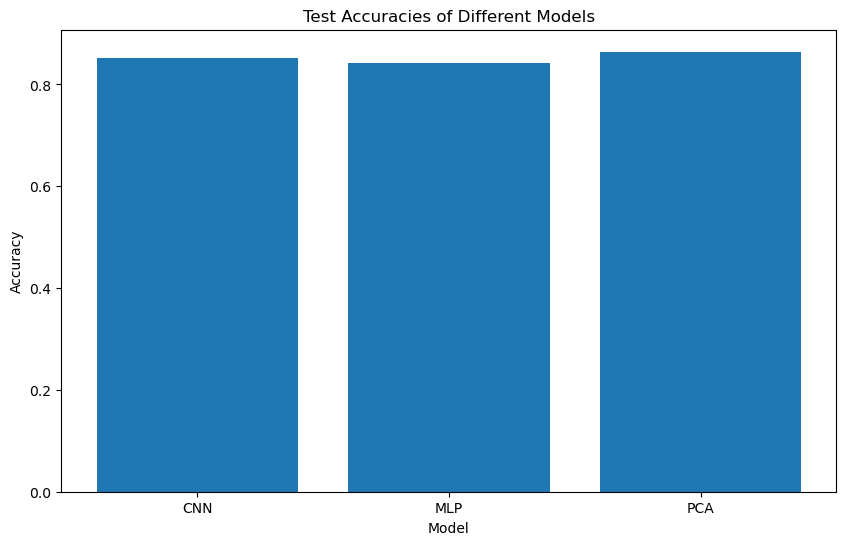

In [34]:
# bar plot for accuracies 
plt.figure(figsize=(10, 6))
accuracies = [cnn_test_accuracy, mlp_test_accuracy, pca_test_accuracy]
x = np.arange(len(accuracies))
plt.bar(x, accuracies)
plt.xticks(x, ['CNN', 'MLP', 'PCA'])
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Test Accuracies of Different Models")
plt.show()

The accuracies are almost similar on 256 taken as the latent dimension.

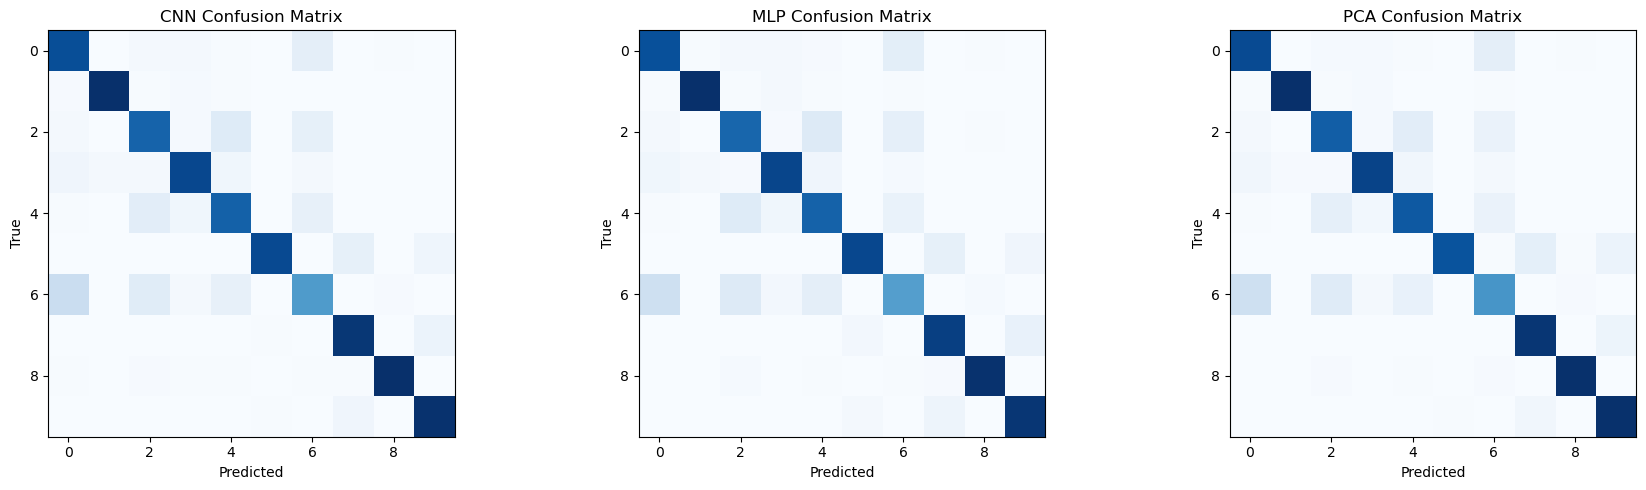

In [40]:
# confusion matrix
cm_cnn = pm.confusion_matrix(y_test, knn_cnn_predictions_test)
cm_mlp = pm.confusion_matrix(y_test, knn_mlp_predictions_test)
cm_pca = pm.confusion_matrix(y_test, knn_pca_predictions_test)

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# CNN
axs[0].imshow(cm_cnn, cmap='Blues')
axs[0].set_title("CNN Confusion Matrix")
axs[0].set_xlabel("Predicted")
axs[0].set_ylabel("True")

# MLP
axs[1].imshow(cm_mlp, cmap='Blues')
axs[1].set_title("MLP Confusion Matrix")
axs[1].set_xlabel("Predicted")
axs[1].set_ylabel("True")

# PCA
axs[2].imshow(cm_pca, cmap='Blues')
axs[2].set_title("PCA Confusion Matrix")
axs[2].set_xlabel("Predicted")
axs[2].set_ylabel("True")

plt.tight_layout()
plt.show()


Analysis from the consufion matrix:

- Each matrix generally shows strong diagonal entries, indicating that each model classifies most instances correctly.
- For classes 1,7,8,9 all 3 models perform the best as indicated by dark blue squares in the confusion matrix.
- For class 6 the performance is the least as indicated by the light blue square in all 3 models.
- For class 5, CNN and MLP perform better than PCA.